# Method: RNN
# Dataset: Lorenz-96, F = 8
# Purpose: Prediction

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from functools import partial

import jax
import jax.numpy as jnp
from jax.nn.initializers import glorot_normal, normal
from jax.example_libraries import optimizers

In [3]:
SEED = 42

In [4]:
train, test = load_data("Lorenz 96, F = 8", "../../data/lorenz8", 0.5)

In [5]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (90000, 40)
Test size: (90000, 40)


**Create test set**

In [6]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [7]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 2000 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [8]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 40)
Test output size: (100, 400, 40)


# 2. RNN Implementation

In [9]:
def RNN(h_dim, data_dim, alpha = 1, W_init = glorot_normal(), b_init = normal()):
    """
    args:
    ====
     h_dim: dimension of the internal state
     data_dim: dimensionity of the time series

    outputs:
    ======
     init_fun: function to initialize the parameters
     process: function to process a time-series and compute the final prediction and final internal state
     forecast: function that, given a pair (internal-state, input), computes the next T predictions
    """

    def init_fun(rng):
        """
        This function initialize the weights of the RNN

        args:
        ====
         rng: jax RNG

        outputs:
        ======
         params: a tuple of parameters
        """

        k1, k2, k3, k4, k5 = jax.random.split(rng, num = 5)
        W_in   = W_init(k1, (h_dim, data_dim))  # data to internal-state
        W_out  = W_init(k2, (data_dim, h_dim))  # internal-state to output 
        W_h    = W_init(k3, (h_dim, h_dim))     # internal-state to internal-state
        h_bias = b_init(k4, (h_dim, ))
        W_bias = b_init(k5, (data_dim, ))

        params = (W_in, W_out, W_h, h_bias, W_bias)
        return params

    def process(params, time_series):
        """
        This function takes a time-series in input, pass it through the RNN, 
        and finally outputs the last prediction and internal state

        args:
        ====
         params: tuple of parameters
         time_series: data of dimension (T, dim_data)

        outputs:
        =======
         h_last: jax vector of dimension nn_size
         pred_traj[-1]: last prediction
        """
        # extract parameters
        W_in, W_out, W_h, h_bias, W_bias = params

        # initial hidden state is set to zero
        h_zero = jnp.zeros((h_dim, ))

        # forward pass
        # RNN: internal function to process data
        def process_internal(hidden, x):
            h_new = (1-alpha)*hidden + alpha * jnp.tanh( W_h@hidden + W_in@x + h_bias)
            #out   = W_out@jnp.concatenate([h_new, jnp.tanh(x)])
            out   = x + W_out @ h_new + W_bias
            return h_new, out
        h_final, pred_traj = jax.lax.scan(process_internal, h_zero, time_series)

        return h_final, pred_traj[-1]

    def forecast(params, h_internal, x_input, horizon):
        """
        This function takes in an internal state and a first input and produces 
        prediction over a finite horizon.

        args:
        ====
         params: tuple of parameters
         h_internal:
         x_input: jax vector of dimension dim_data
         horizon: horizon of the prediction

        outputs:
        =======
         preds: a trajectory of prediction of dimension (horison, dim_data) 
        """
        # extract parameters
        W_in, W_out, W_h, h_bias, W_bias = params

        # forward pass
        # RNN: internal function to process data
        def forecast_internal(pair_h_x, _ ):
            hidden, x = pair_h_x
            h_new = (1-alpha) * hidden + alpha * jnp.tanh( W_h @ hidden + W_in @ x + h_bias)
            out   = x + W_out @ h_new + W_bias
            return (h_new, out), out 
        _, pred_traj = jax.lax.scan(forecast_internal, (h_internal, x_input), None, length=horizon)

        # return the trajectory of predictions
        return pred_traj

    return init_fun, process, forecast

In [10]:
def get_parameters(nn_size, seed, batch_size, L_past, L_forecast_train, 
                   num_epoch, lr_schedule, early_stopping = EARLY_STOPPING, 
                  early_stopping_baseline = 1.2):
    assert len(num_epoch) == len(lr_schedule)
    def training(x, y, init_params):
        @jax.jit
        def step(i, opt_state, x_batch, y_batch):
            params = get_params(opt_state)
            value, g = jax.value_and_grad(mse)(params, x_batch, y_batch)
            opt_state = opt_update(i, g, opt_state)
            return get_params(opt_state), opt_state, value
        
        @partial(jax.jit, static_argnums=2)
        def make_forecast(params, x_batch, horizon):
            # pass the data through the RNN. 
            # note that "preds" is the first forecasts
            hs, preds = process_batch(params, x_batch)
            # compute the (L_forecast-1) next forecasts
            y_pred = forecast_batch(params, hs, preds, horizon-1)
            #stick all the forecasts together
            y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

            return y_pred

        @jax.jit
        def mse(params, x_batch, y_truth):
            """
            For each time-series in a batch, forecasts over a finite horizon 
            and compute the MSE.

            args:
            ====
             params: neural parameters
             x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
             y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

            outputs:
            =======
             MSE: MSE between forecasts and targets
            """

            # horizon of the forecast
            L_forecast = y_truth.shape[1]    
            y_pred = make_forecast(params, x_batch, L_forecast)

            #compute MSE
            error = y_pred - y_truth
            mu_loss = jnp.mean(error**2)
            return mu_loss 
        
        start = time()
                
        loss_train_traj = []
        loss_train_all_traj = []
        
        best_params = init_params
        overall_best_mse = 999999999
        
        # train/val split
        t_size = int(0.9 * train_size)
        v_size = train_size - t_size
        T_indices_val = np.arange(t_size, train_size - (L_forecast_test + L_past))
        t_start_val = T_indices_val[::10]
        t_past_batch_val = (t_start_val[:,None] + np.arange(L_past)[None,:]).astype(int) 
        t_pred_batch_val = (t_start_val[:,None] + np.arange(L_past,L_past+L_forecast_test)[None,:]).astype(int) 
        x_val = data_test[t_past_batch_val]
        y_val = data_test[t_pred_batch_val]
        
        
        print("Backpropogation start", end = "\n\n")
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init(best_params)
            counter = 0
            best_mse = 999999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                # randomize the order of the training data
                T_indices = np.arange(t_size - (L_forecast_train + L_past))
                np.random.shuffle(T_indices)
                
                # training
                loss_epoch_train = []
                
                for k in range(t_size // batch_size + 1):
                    # create a batch of data
                    t_start = T_indices[np.arange(k*batch_size, (k+1)*batch_size).astype(int) % len(T_indices)] # start of each time series in the batch
                    # create 2d array of dimension (batch_size, L_past) containing all the time indices
                    t_past_batch = (t_start[:,None] + np.arange(L_past)[None,:]).astype(int) # transposes data
                    t_pred_batch = (t_start[:,None] + np.arange(L_past,L_past+L_forecast_train)[None,:]).astype(int) 

                    #create batch of dimension (batch_size, L_past, data_dim)
                    x_batch = x[t_past_batch]  
                    y_batch = y[t_pred_batch]

                    params, opt_state, loss_current = step(k, opt_state, x_batch, y_batch) # update
                    loss_epoch_train.append(loss_current)
                
                mse_train = np.mean(loss_epoch_train)
                
                # validation             
                mse_val = mse(params, x_val, y_val)
                
                if  best_mse > mse_val: # Improvement
                    counter = 0
                    best_mse = mse_val
                    best_params = params
                else:
                    counter += 1
                
                e_end = time()
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch >= 50):
                    print(f"Epoch {epoch + 1}: Time taken = {e_end - e_start:.2f} | Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                
                if best_mse < early_stopping_baseline and counter >= early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f} | Val loss = {mse_val: .7f}")
                    break
            print(f"Best Validation MSE: {best_mse:.7f}")
            
            if best_mse < overall_best_mse: # Best round so far
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_mse
                overall_best_params = best_params
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return overall_best_params

    start = time()
    x, y = train.data[:-1], train.data[1:]
    train_size, data_dim = x.data.shape
    
    np.random.seed(seed)
    key = jax.random.PRNGKey(seed)
    
    # Initialize RNN
    init_fun, process, forecast = RNN(nn_size, data_dim)       # RNN Network
    process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
    forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)
    init_params = init_fun(key)
    
    final_params = training(x, y, init_params)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return final_params, (process_batch, forecast_batch)

In [11]:
def get_test_pred(data_test, params, rnn_fx):  
    @partial(jax.jit, static_argnums=2)
    def make_forecast(params, x_batch, horizon):
        pbatch, fbatch = rnn_fx
        # pass the data through the RNN. 
        # note that "preds" is the first forecasts
        hs, preds = pbatch(params, x_batch)
        # compute the (L_forecast-1) next forecasts
        y_pred = fbatch(params, hs, preds, horizon-1)
        #stick all the forecasts together
        y_pred = jnp.concatenate([preds[:, None,:], y_pred], axis=1)

        return y_pred

    @jax.jit
    def loss(params, x_batch, y_truth):
        """
        For each time-series in a batch, forecasts over a finite horizon 
        and compute the MSE.

        args:
        ====
         params: neural parameters
         x_batch: a batch of inputs with dimension (batch_size, T_past, dim_data)
         y_truth: a batch of values to forecasts with dimension (batch_size, T_future, dim_data)

        outputs:
        =======
         MSE: MSE between forecasts and targets

        """

        # horizon of the forecast
        L_forecast = y_truth.shape[1]    
        y_pred = make_forecast(params, x_batch, L_forecast)

        #compute MSE
        error = y_pred - y_truth
        return jnp.mean(error**2)
    
    start = time()
    num_data_test, L_past, data_dim = data_test.shape # testing ex, # steps used before, dim of data
    mu_pred = make_forecast(params, data_test, L_forecast_test)
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mu_pred)

# 3. Parameter tuning

There are 3 parameters to tune
- nn_size [100, 500, 1000, 1500] - size of the hidden layer
- L_forecast_train [4, 8, 16] - steps forward considered when calculating loss during training
- L_past [1, 8, 16] - length of time series used as input during training 

As a full grid search will be computationally expensive, nn_size is first tuned using a fixed L_forecast_train and L_past, then a grid search is performed on the optimal nn_size

## 3.1 nn_size

**Parameters**
- nn_size = [100, 500, 1000, 1500]
- L_forecast_train = 8
- L_past = 4

In [20]:
L_forecast_train = 8
L_past = 4
b_size = 128 # Batch size
lr_list = [1e-2, 1e-3, 1e-4] # Learning rate schedule
epoch_list = [200, 400, 200]  # Number of epochs for each learning rate

### 3.1.1 nn_size = 100

In [21]:
nn_size = 100

In [22]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,)

Backpropogation start

Epoch 10: Time taken = 1.75 | Train loss = 0.0310072 | Val loss =  8120.8842773
Epoch 20: Time taken = 1.65 | Train loss = 0.0196609 | Val loss =  2153.8464355
Epoch 30: Time taken = 1.61 | Train loss = 0.0155356 | Val loss =  1821.5028076
Epoch 40: Time taken = 1.78 | Train loss = 0.0132557 | Val loss =  1136.5588379
Epoch 50: Time taken = 1.63 | Train loss = 0.0118384 | Val loss =  1156.5872803
Epoch 60: Time taken = 1.83 | Train loss = 0.0107975 | Val loss =  3822.2014160
Epoch 70: Time taken = 2.39 | Train loss = 0.0100107 | Val loss =  3814.9440918
Epoch 80: Time taken = 1.69 | Train loss = 0.0094634 | Val loss =  2121.6572266
Epoch 90: Time taken = 2.56 | Train loss = 0.0090112 | Val loss =  1867.5356445
Epoch 100: Time taken = 1.63 | Train loss = 0.0087170 | Val loss =  2544.1350098
Epoch 110: Time taken = 1.87 | Train loss = 0.0084205 | Val loss =  2762.6516113
Epoch 120: Time taken = 2.30 | Train loss = 0.0081991 | Val loss =  1537.5675049
Epoch 130: Tim

In [23]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_1_1_mu_preds.pkl")

Testing complete. Time taken: 0.44


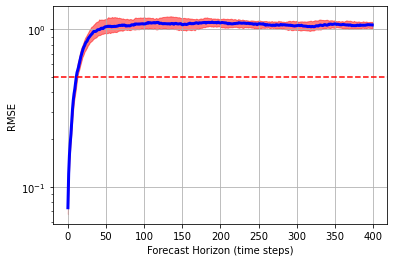

It takes around t = 0.12 for mean error to exceed 0.5


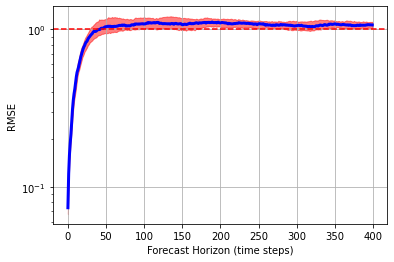

It takes around t = 0.43 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.754
Median NRMSE at t = 0.5: 1.039
Median NRMSE at t = 1: 1.083
Median NRMSE at t = 2: 1.099
Median NRMSE at t = 3: 1.055


In [24]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.2 nn_size = 500

In [25]:
nn_size = 500
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

In [26]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.61 | Train loss = 0.0058496 | Val loss =  16.9472618
Epoch 20: Time taken = 1.55 | Train loss = 0.0019176 | Val loss =  2.3674254
Epoch 30: Time taken = 1.55 | Train loss = 0.0012730 | Val loss =  3.2737677
Epoch 40: Time taken = 1.43 | Train loss = 0.0010324 | Val loss =  5.0500655
Epoch 50: Time taken = 1.44 | Train loss = 0.0008356 | Val loss =  260.4396362
Epoch 60: Time taken = 1.43 | Train loss = 0.0007473 | Val loss =  48.0825958
Epoch 70: Time taken = 1.40 | Train loss = 0.0006404 | Val loss =  11.7665358
Epoch 80: Time taken = 1.49 | Train loss = 0.0005711 | Val loss =  3.2729948
Epoch 90: Time taken = 1.42 | Train loss = 0.0005313 | Val loss =  4.8984942
Epoch 100: Time taken = 1.53 | Train loss = 0.0027062 | Val loss =  25.8566322
Epoch 110: Time taken = 1.63 | Train loss = 0.0006465 | Val loss =  2193.3376465
Epoch 120: Time taken = 1.57 | Train loss = 0.0026706 | Val loss =  84.6732330
Epoch 130: Time taken = 2.53 | Train los

In [27]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_1_2_mu_preds.pkl")

Testing complete. Time taken: 0.42


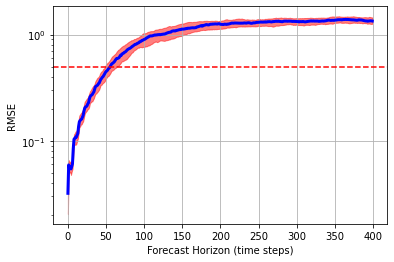

It takes around t = 0.56 for mean error to exceed 0.5


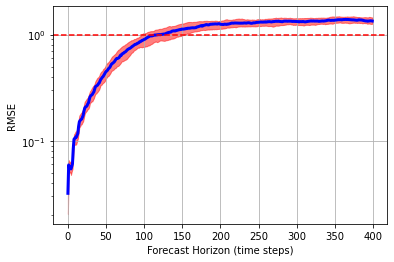

It takes around t = 1.23 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.173
Median NRMSE at t = 0.5: 0.449
Median NRMSE at t = 1: 0.899
Median NRMSE at t = 2: 1.248
Median NRMSE at t = 3: 1.325


In [28]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.3 nn_size = 1000

In [29]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate
nn_size = 1000

In [30]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 2.45 | Train loss = 0.0034941 | Val loss =  4.8461995
Epoch 20: Time taken = 2.44 | Train loss = 0.0016588 | Val loss =  3.4867220
Epoch 30: Time taken = 2.46 | Train loss = 0.0010470 | Val loss =  5.9403262
Epoch 40: Time taken = 2.45 | Train loss = 0.0061875 | Val loss =  2.2339530
Epoch 50: Time taken = 2.46 | Train loss = 0.0026799 | Val loss =  2.2685947
Epoch 51: Time taken = 2.45 | Train loss = 0.0025110 | Val loss =  1.7263135
Epoch 60: Time taken = 2.46 | Train loss = 0.0016970 | Val loss =  2.1861734
Epoch 70: Time taken = 2.46 | Train loss = 0.0013527 | Val loss =  2.9265590
Epoch 80: Time taken = 2.48 | Train loss = 0.0011313 | Val loss =  2.8928528
Epoch 90: Time taken = 2.46 | Train loss = 0.0010434 | Val loss =  2.2528608
Epoch 100: Time taken = 2.48 | Train loss = 0.0009450 | Val loss =  2.8239501
Epoch 110: Time taken = 2.48 | Train loss = 0.0008909 | Val loss =  2.4512277
Epoch 120: Time taken = 2.49 | Train loss = 0.00085

In [31]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_1_3_mu_preds.pkl")

Testing complete. Time taken: 0.69


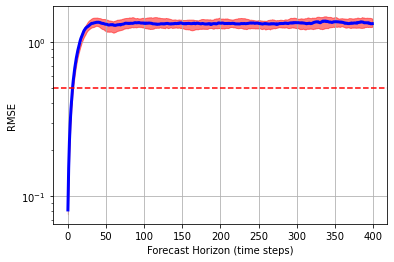

It takes around t = 0.06 for mean error to exceed 0.5


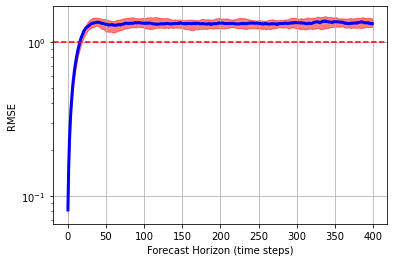

It takes around t = 0.16 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 1.154
Median NRMSE at t = 0.5: 1.310
Median NRMSE at t = 1: 1.333
Median NRMSE at t = 2: 1.331
Median NRMSE at t = 3: 1.341


In [32]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 nn_size = 1500

In [33]:
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate
nn_size = 1500

In [34]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 4.31 | Train loss = 0.0031139 | Val loss =  1.9010659
Epoch 20: Time taken = 4.32 | Train loss = 0.0014424 | Val loss =  2.7167797
Epoch 30: Time taken = 4.30 | Train loss = 0.0658564 | Val loss =  1.0006731
Epoch 40: Time taken = 4.31 | Train loss = 0.0516998 | Val loss =  1.6093665
Epoch 50: Time taken = 4.29 | Train loss = 0.0317468 | Val loss =  12.1189747
Epoch 60: Time taken = 4.29 | Train loss = 0.0213745 | Val loss =  268.4829407
EARLY STOPPING. Epoch 60: Train loss = 0.0213745 | Val loss =  268.4829407
Best Validation MSE: 1.0006731
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 4.30 | Train loss = 0.0632503 | Val loss =  1.2979667
Epoch 20: Time taken = 4.31 | Train loss = 0.0528857 | Val loss =  1.5476526
Epoch 30: Time taken = 4.31 | Train loss = 0.0449997 | Val loss =  6.3465466
EARLY STOPPING. Epoch 35: Train loss = 0.0417012 | Val loss =  1.8986831
Best Validation MSE: 1.1149040

Epoch 10: Time taken = 4.28 | Train loss = 0.

In [35]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_1_4_mu_preds.pkl")

Testing complete. Time taken: 0.67


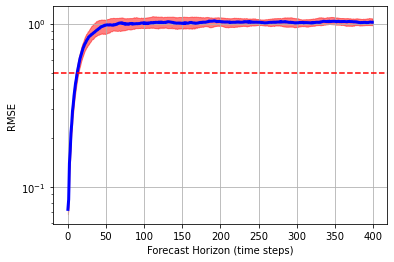

It takes around t = 0.13 for mean error to exceed 0.5


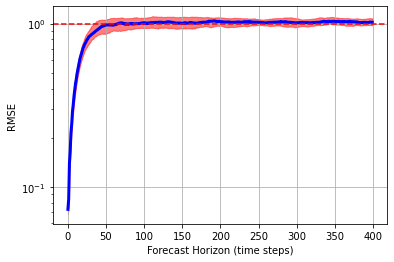

It takes around t = 0.66 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.710
Median NRMSE at t = 0.5: 0.981
Median NRMSE at t = 1: 1.002
Median NRMSE at t = 2: 1.028
Median NRMSE at t = 3: 1.011


In [36]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 L_forecast_train + L_past

**Parameters**
- nn_size = 1000
- L_forecast_train = [1, 8, 16]
- L_past = [4, 8, 16]

In [37]:
nn_size = 500
lr_list = [1e-3, 1e-4, 1e-5] # Learning rate schedule
epoch_list = [400, 200, 200]  # Number of epochs for each learning rate

### 3.2.1 L_forecast_train = 4, L_past = 1

In [38]:
L_forecast_train = 4; L_past = 1

In [39]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 0.83 | Train loss = 0.0033849 | Val loss =  1301.7730713
Epoch 20: Time taken = 0.79 | Train loss = 0.0013736 | Val loss =  538.3697510
Epoch 30: Time taken = 0.77 | Train loss = 0.0008296 | Val loss =  372.5932922
Epoch 40: Time taken = 0.78 | Train loss = 0.0005986 | Val loss =  336.3481140
Epoch 50: Time taken = 0.82 | Train loss = 0.0004669 | Val loss =  118.3559952
Epoch 51: Time taken = 0.82 | Train loss = 0.0004595 | Val loss =  83.9267960
Epoch 52: Time taken = 0.75 | Train loss = 0.0004444 | Val loss =  72.9417267
Epoch 54: Time taken = 0.78 | Train loss = 0.0004324 | Val loss =  52.0253487
Epoch 58: Time taken = 0.76 | Train loss = 0.0003914 | Val loss =  47.6762352
Epoch 59: Time taken = 0.78 | Train loss = 0.0004048 | Val loss =  47.6144333
Epoch 60: Time taken = 0.81 | Train loss = 0.0003944 | Val loss =  51.5792656
Epoch 62: Time taken = 0.81 | Train loss = 0.0003763 | Val loss =  40.1069031
Epoch 63: Time taken = 0.81 | Train

In [40]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_1_mu_preds.pkl")

Testing complete. Time taken: 0.30


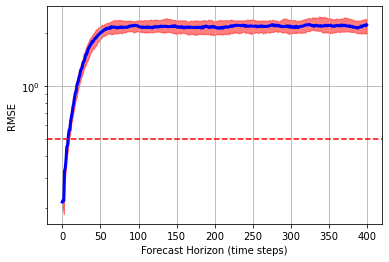

It takes around t = 0.08 for mean error to exceed 0.5


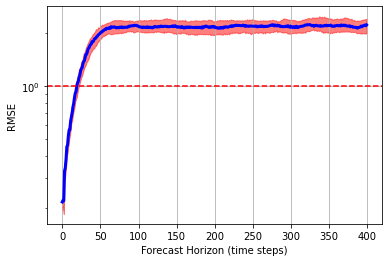

It takes around t = 0.20 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 1.041
Median NRMSE at t = 0.5: 2.009
Median NRMSE at t = 1: 2.185
Median NRMSE at t = 2: 2.179
Median NRMSE at t = 3: 2.165


In [41]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 L_forecast_train = 4, L_past = 4

In [42]:
L_forecast_train = 4; L_past = 4

In [43]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.19 | Train loss = 0.0043029 | Val loss =  33659.4140625
Epoch 20: Time taken = 1.13 | Train loss = 0.0032751 | Val loss =  55497.9218750
Epoch 30: Time taken = 1.11 | Train loss = 0.0023896 | Val loss =  66857.7890625
Epoch 40: Time taken = 1.21 | Train loss = 0.0017912 | Val loss =  66602.4140625
Epoch 50: Time taken = 1.19 | Train loss = 0.0014065 | Val loss =  57998.8125000
Epoch 60: Time taken = 1.13 | Train loss = 0.0011209 | Val loss =  45403.9765625
Epoch 70: Time taken = 1.15 | Train loss = 0.0008998 | Val loss =  34511.4101562
Epoch 80: Time taken = 1.17 | Train loss = 0.0007296 | Val loss =  25305.2636719
Epoch 90: Time taken = 1.16 | Train loss = 0.0006067 | Val loss =  18710.0839844
Epoch 99: Time taken = 1.40 | Train loss = 0.0005175 | Val loss =  14515.0380859
Epoch 100: Time taken = 1.23 | Train loss = 0.0005028 | Val loss =  14732.3759766
Epoch 101: Time taken = 1.20 | Train loss = 0.0005050 | Val loss =  14111.8232422
Epo

In [44]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_2_mu_preds.pkl")

Testing complete. Time taken: 0.27


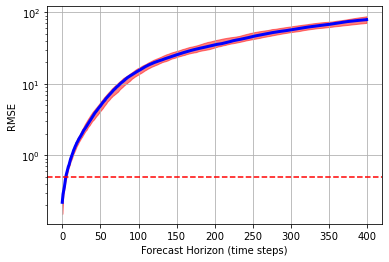

It takes around t = 0.05 for mean error to exceed 0.5


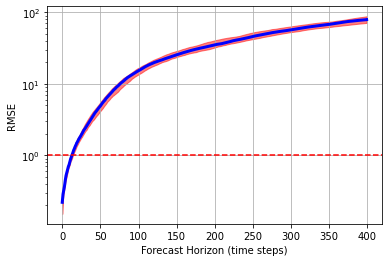

It takes around t = 0.13 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 1.550
Median NRMSE at t = 0.5: 4.905
Median NRMSE at t = 1: 15.269
Median NRMSE at t = 2: 35.237
Median NRMSE at t = 3: 57.071


In [45]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.3 L_forecast_train = 4, L_past = 8

In [46]:
L_forecast_train = 4; L_past = 8

In [47]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.44 | Train loss = 0.0052291 | Val loss =  2640.8583984
Epoch 20: Time taken = 1.34 | Train loss = 0.0033317 | Val loss =  1370.8439941
Epoch 30: Time taken = 1.38 | Train loss = 0.0021611 | Val loss =  1691.9125977
Epoch 40: Time taken = 1.37 | Train loss = 0.0015177 | Val loss =  2041.3209229
Epoch 50: Time taken = 1.34 | Train loss = 0.0010955 | Val loss =  2400.0942383
Epoch 60: Time taken = 1.38 | Train loss = 0.0008138 | Val loss =  3065.1064453
Epoch 70: Time taken = 1.36 | Train loss = 0.0006515 | Val loss =  3387.8415527
Epoch 80: Time taken = 1.36 | Train loss = 0.0005415 | Val loss =  3413.8015137
Epoch 90: Time taken = 1.35 | Train loss = 0.0004748 | Val loss =  3324.3264160
Epoch 100: Time taken = 1.35 | Train loss = 0.0004231 | Val loss =  3239.0761719
Epoch 110: Time taken = 1.39 | Train loss = 0.0003787 | Val loss =  3074.0283203
Epoch 120: Time taken = 1.38 | Train loss = 0.0003521 | Val loss =  2965.7211914
Epoch 130: Tim

In [48]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_3_mu_preds.pkl")

Testing complete. Time taken: 0.29


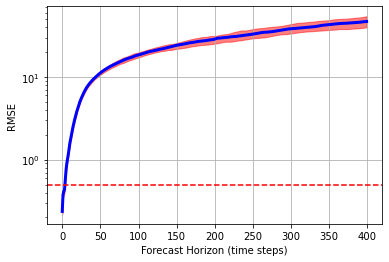

It takes around t = 0.04 for mean error to exceed 0.5


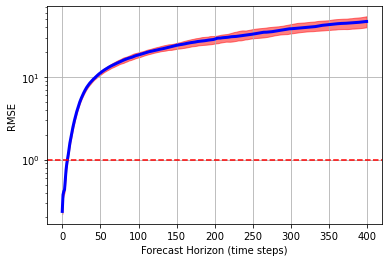

It takes around t = 0.07 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 4.085
Median NRMSE at t = 0.5: 11.190
Median NRMSE at t = 1: 18.488
Median NRMSE at t = 2: 28.730
Median NRMSE at t = 3: 38.342


In [49]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.4 L_forecast_train = 8, L_past = 1

In [50]:
L_forecast_train = 8; L_past = 1

In [51]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.27 | Train loss = 0.0063222 | Val loss =  70.5972900
Epoch 20: Time taken = 1.16 | Train loss = 0.0027480 | Val loss =  1.7048643
Epoch 30: Time taken = 1.17 | Train loss = 0.0017997 | Val loss =  1.6753834
Epoch 40: Time taken = 1.16 | Train loss = 0.0013707 | Val loss =  1.6079026
Epoch 50: Time taken = 1.21 | Train loss = 0.0010521 | Val loss =  1.5795442
Epoch 60: Time taken = 1.18 | Train loss = 0.0009074 | Val loss =  1.6238621
Epoch 66: Time taken = 1.21 | Train loss = 0.0006964 | Val loss =  1.3758957
Epoch 70: Time taken = 1.26 | Train loss = 0.0046307 | Val loss =  859.6276245
Epoch 80: Time taken = 1.16 | Train loss = 0.0007015 | Val loss =  1.7473805
Epoch 90: Time taken = 1.21 | Train loss = 0.0008595 | Val loss =  35.5079842
Epoch 100: Time taken = 1.19 | Train loss = 0.0006622 | Val loss =  204.2476196
Epoch 110: Time taken = 1.14 | Train loss = 0.0006008 | Val loss =  170.1792755
Epoch 120: Time taken = 1.25 | Train loss =

In [52]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_4_mu_preds.pkl")

Testing complete. Time taken: 0.24


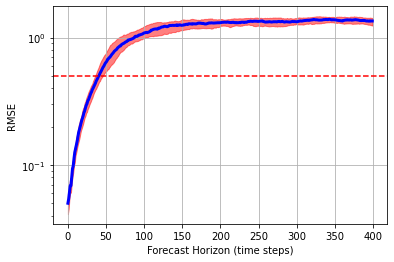

It takes around t = 0.41 for mean error to exceed 0.5


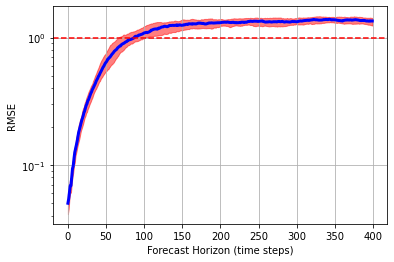

It takes around t = 0.88 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.243
Median NRMSE at t = 0.5: 0.641
Median NRMSE at t = 1: 1.088
Median NRMSE at t = 2: 1.311
Median NRMSE at t = 3: 1.331


In [53]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.5 L_forecast_train = 8, L_past = 4

In [54]:
L_forecast_train = 8; L_past = 4

In [55]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.36 | Train loss = 0.0058496 | Val loss =  16.9472618
Epoch 20: Time taken = 1.33 | Train loss = 0.0019176 | Val loss =  2.3674254
Epoch 30: Time taken = 1.34 | Train loss = 0.0012730 | Val loss =  3.2737677
Epoch 40: Time taken = 1.34 | Train loss = 0.0010324 | Val loss =  5.0500655
Epoch 50: Time taken = 1.31 | Train loss = 0.0008356 | Val loss =  260.4396362
Epoch 60: Time taken = 1.36 | Train loss = 0.0007473 | Val loss =  48.0825958
Epoch 70: Time taken = 1.41 | Train loss = 0.0006404 | Val loss =  11.7665358
Epoch 80: Time taken = 1.36 | Train loss = 0.0005711 | Val loss =  3.2729948
Epoch 90: Time taken = 1.33 | Train loss = 0.0005313 | Val loss =  4.8984942
Epoch 100: Time taken = 1.31 | Train loss = 0.0027062 | Val loss =  25.8566322
Epoch 110: Time taken = 1.35 | Train loss = 0.0006465 | Val loss =  2193.3376465
Epoch 120: Time taken = 1.34 | Train loss = 0.0026706 | Val loss =  84.6732330
Epoch 130: Time taken = 1.34 | Train los

In [56]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_5_mu_preds.pkl")

Testing complete. Time taken: 0.27


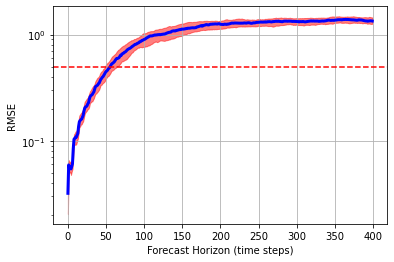

It takes around t = 0.56 for mean error to exceed 0.5


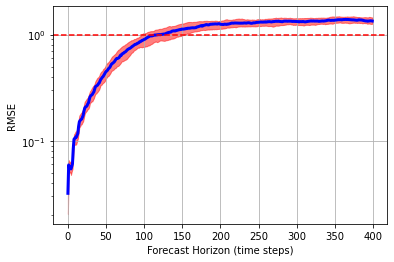

It takes around t = 1.23 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.173
Median NRMSE at t = 0.5: 0.449
Median NRMSE at t = 1: 0.899
Median NRMSE at t = 2: 1.248
Median NRMSE at t = 3: 1.325


In [57]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.6 L_forecast_train = 8, L_past = 8

In [58]:
L_forecast_train = 8; L_past = 8

In [59]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.76 | Train loss = 0.0192360 | Val loss =  30.5897713
Epoch 20: Time taken = 1.94 | Train loss = 0.0069476 | Val loss =  13.6072788
Epoch 30: Time taken = 1.73 | Train loss = 0.0023986 | Val loss =  10.4363270
Epoch 40: Time taken = 1.65 | Train loss = 0.0013952 | Val loss =  7.6247768
Epoch 50: Time taken = 1.63 | Train loss = 0.0010661 | Val loss =  1.7278435
Epoch 51: Time taken = 1.67 | Train loss = 0.0010116 | Val loss =  1.5668732
Epoch 56: Time taken = 1.80 | Train loss = 0.0009372 | Val loss =  1.5447838
Epoch 57: Time taken = 1.68 | Train loss = 0.0009256 | Val loss =  1.5045352
Epoch 60: Time taken = 1.63 | Train loss = 0.0008717 | Val loss =  1.5149697
Epoch 70: Time taken = 1.60 | Train loss = 0.0007926 | Val loss =  1.6015005
Epoch 72: Time taken = 1.62 | Train loss = 0.0007769 | Val loss =  1.4669137
Epoch 80: Time taken = 1.61 | Train loss = 0.0007034 | Val loss =  1.5689555
Epoch 89: Time taken = 1.60 | Train loss = 0.00068

In [60]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_6_mu_preds.pkl")

Testing complete. Time taken: 0.28


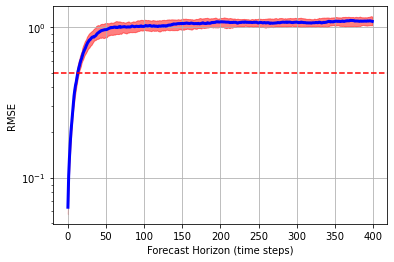

It takes around t = 0.13 for mean error to exceed 0.5


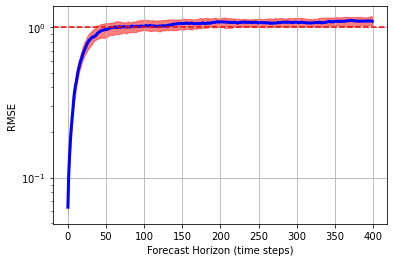

It takes around t = 0.58 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.676
Median NRMSE at t = 0.5: 0.968
Median NRMSE at t = 1: 1.017
Median NRMSE at t = 2: 1.090
Median NRMSE at t = 3: 1.086


In [61]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.7 L_forecast_train = 16, L_past = 1

In [62]:
L_forecast_train = 16; L_past = 1

In [63]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.84 | Train loss = 0.0260664 | Val loss =  49.8096237
Epoch 20: Time taken = 1.75 | Train loss = 0.0074051 | Val loss =  1.4037681
Epoch 30: Time taken = 1.63 | Train loss = 0.0047370 | Val loss =  1.3701659
EARLY STOPPING. Epoch 32: Train loss = 0.0045698 | Val loss =  1.3266979
Best Validation MSE: 0.9510590
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 1.76 | Train loss = 0.0321967 | Val loss =  1.2801837
Epoch 20: Time taken = 1.91 | Train loss = 0.0056765 | Val loss =  1.3059857
Epoch 30: Time taken = 1.72 | Train loss = 0.0033646 | Val loss =  1.2569299
EARLY STOPPING. Epoch 31: Train loss = 0.0032328 | Val loss =  1.3506799
Best Validation MSE: 0.9093519
IMPROVED VALIDATION MSE

Epoch 10: Time taken = 1.86 | Train loss = 0.0164617 | Val loss =  1.9488614
Epoch 20: Time taken = 1.99 | Train loss = 0.0078821 | Val loss =  3.2112131
Epoch 30: Time taken = 1.87 | Train loss = 0.0055894 | Val loss =  6.7103887
EARLY STOPPING. Epoch 31:

In [64]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_7_mu_preds.pkl")

Testing complete. Time taken: 0.26


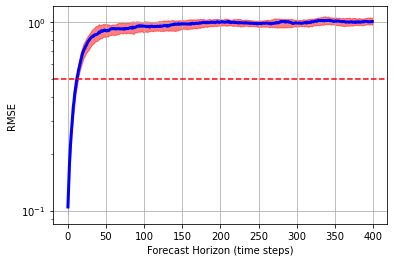

It takes around t = 0.12 for mean error to exceed 0.5


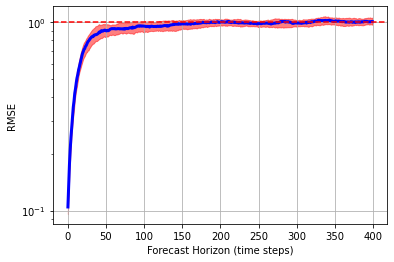

It takes around t = 1.88 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.696
Median NRMSE at t = 0.5: 0.900
Median NRMSE at t = 1: 0.954
Median NRMSE at t = 2: 1.000
Median NRMSE at t = 3: 0.990


In [65]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.8 L_forecast_train = 16, L_past = 4

In [66]:
L_forecast_train = 16; L_past = 4

In [67]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 1.94 | Train loss = 0.0180563 | Val loss =  1.6596134
Epoch 20: Time taken = 1.98 | Train loss = 0.0063636 | Val loss =  1.4631964
Epoch 30: Time taken = 2.25 | Train loss = 0.0041569 | Val loss =  1.4815714
Epoch 40: Time taken = 2.17 | Train loss = 0.0032136 | Val loss =  1.2859910
Epoch 50: Time taken = 2.03 | Train loss = 0.0027314 | Val loss =  1.3192011
Epoch 56: Time taken = 2.16 | Train loss = 0.0024659 | Val loss =  1.2714635
Epoch 60: Time taken = 1.94 | Train loss = 0.0022120 | Val loss =  1.3117720
Epoch 69: Time taken = 1.93 | Train loss = 0.0019121 | Val loss =  1.2690445
Epoch 70: Time taken = 1.93 | Train loss = 0.0019601 | Val loss =  1.3969687
Epoch 71: Time taken = 1.96 | Train loss = 0.0019952 | Val loss =  1.2225517
Epoch 80: Time taken = 2.19 | Train loss = 0.0034621 | Val loss =  1.1983101
Epoch 90: Time taken = 2.08 | Train loss = 0.0070498 | Val loss =  9.1891651
Epoch 100: Time taken = 2.04 | Train loss = 0.0086913

In [68]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_8_mu_preds.pkl")

Testing complete. Time taken: 0.25


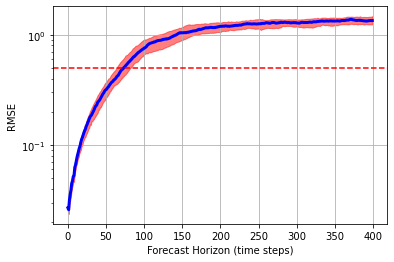

It takes around t = 0.74 for mean error to exceed 0.5


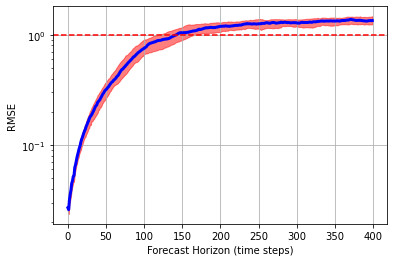

It takes around t = 1.43 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.124
Median NRMSE at t = 0.5: 0.318
Median NRMSE at t = 1: 0.759
Median NRMSE at t = 2: 1.196
Median NRMSE at t = 3: 1.282


In [69]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.9 L_forecast_train = 16, L_past = 8

In [70]:
L_forecast_train = 16; L_past = 8

In [71]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list)

Backpropogation start

Epoch 10: Time taken = 2.15 | Train loss = 0.0241748 | Val loss =  1.7377526
Epoch 20: Time taken = 2.15 | Train loss = 0.0068224 | Val loss =  1.6308520
Epoch 30: Time taken = 2.41 | Train loss = 0.0042734 | Val loss =  1.5559680
Epoch 40: Time taken = 2.26 | Train loss = 0.0035077 | Val loss =  1.3335770
Epoch 50: Time taken = 2.21 | Train loss = 0.0028677 | Val loss =  1.3144866
Epoch 55: Time taken = 2.33 | Train loss = 0.0026919 | Val loss =  1.3075325
Epoch 57: Time taken = 2.31 | Train loss = 0.0025816 | Val loss =  1.2908808
Epoch 60: Time taken = 2.49 | Train loss = 0.0023356 | Val loss =  1.3378203
Epoch 64: Time taken = 2.20 | Train loss = 0.0024889 | Val loss =  1.2750014
Epoch 70: Time taken = 2.58 | Train loss = 0.0022721 | Val loss =  1.3783098
Epoch 74: Time taken = 2.54 | Train loss = 0.0021070 | Val loss =  1.2642552
Epoch 78: Time taken = 2.49 | Train loss = 0.0051037 | Val loss =  1.2147911
Epoch 80: Time taken = 2.60 | Train loss = 0.0073860 

In [72]:
mean_pred = get_test_pred(X_test, params, rnn_fx)
save_obj(mean_pred, "results/rnn", "3_2_9_mu_preds.pkl")

Testing complete. Time taken: 0.27


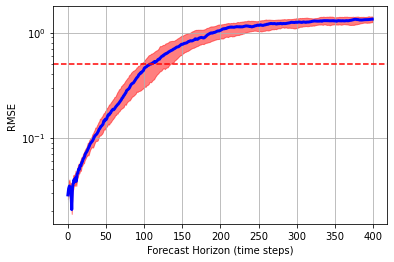

It takes around t = 1.08 for mean error to exceed 0.5


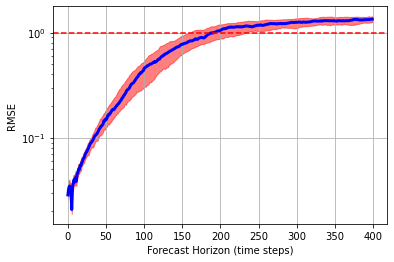

It takes around t = 1.91 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.063
Median NRMSE at t = 0.5: 0.148
Median NRMSE at t = 1: 0.457
Median NRMSE at t = 2: 1.051
Median NRMSE at t = 3: 1.254


In [73]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Best Model

nn_size = 500  
L_forecast_train = 4  
L_past = 4

In [12]:
nn_size = 500
L_forecast_train = 16
L_past = 8

b_size = 128 # Batch size
lr_list = [1e-3, 1e-4, 1e-5, 1e-6] # Learning rate schedule
epoch_list = [400, 200, 200, 200]  # Number of epochs for each learning rate

In [16]:
params, rnn_fx = get_parameters(nn_size = nn_size, seed = SEED, batch_size = b_size, L_past = L_past, 
                                 L_forecast_train = L_forecast_train, num_epoch = epoch_list, lr_schedule = lr_list,
                                early_stopping = 50)

Backpropogation start

Epoch 10: Time taken = 2.72 | Train loss = 0.0237621 | Val loss =  1.7527591
Epoch 20: Time taken = 2.64 | Train loss = 0.0071708 | Val loss =  1.6403352
Epoch 30: Time taken = 2.76 | Train loss = 0.0044853 | Val loss =  1.4709992
Epoch 40: Time taken = 3.01 | Train loss = 0.0035812 | Val loss =  1.4172482
Epoch 50: Time taken = 3.09 | Train loss = 0.0029594 | Val loss =  1.4008662
Epoch 57: Time taken = 3.01 | Train loss = 0.0026940 | Val loss =  1.3124071
Epoch 60: Time taken = 3.01 | Train loss = 0.0025243 | Val loss =  1.3143660
Epoch 61: Time taken = 2.68 | Train loss = 0.0025275 | Val loss =  1.2604183
Epoch 70: Time taken = 2.80 | Train loss = 0.0062651 | Val loss =  1.4909233
Epoch 74: Time taken = 2.76 | Train loss = 0.0043479 | Val loss =  1.1970789
Epoch 80: Time taken = 2.71 | Train loss = 0.0032433 | Val loss =  1.2278076
Epoch 90: Time taken = 3.04 | Train loss = 0.0052413 | Val loss =  1639.4686279
Epoch 100: Time taken = 3.07 | Train loss = 0.0027

In [17]:
mean_pred = get_test_pred(X_test, params, rnn_fx)

Testing complete. Time taken: 0.38


In [18]:
save_obj(params, "results/rnn", "best_params.pkl")
save_obj(mean_pred, "results/rnn", "best_mu_preds.pkl")

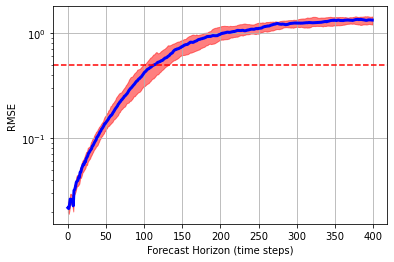

It takes around t = 1.15 for mean error to exceed 0.5


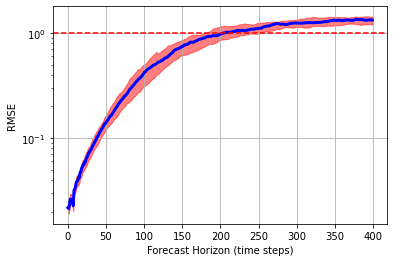

It takes around t = 2.06 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.056
Median NRMSE at t = 0.5: 0.141
Median NRMSE at t = 1: 0.418
Median NRMSE at t = 2: 0.971
Median NRMSE at t = 3: 1.240


In [19]:
desc_name = "rnn_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 5. Plot images based on Lyapunov Time

In [17]:
nn_size = 500
_, process, forecast = RNN(nn_size, data_dim)       # RNN Network
process_batch = jax.jit(jax.vmap(process, in_axes=(None,0)))
forecast_batch = jax.jit(jax.vmap(forecast, in_axes=(None,0,0,None)), static_argnums=3)

In [18]:
params = load_obj("results/rnn/best_params.pkl")

In [19]:
mean_pred = get_test_pred(X_test, params, (process_batch, forecast_batch))
save_obj(mean_pred, "results", "rnn_pred.pkl")

Testing complete. Time taken: 0.33


In [9]:
mean_pred = load_obj("results/rnn_pred.pkl")

In [10]:
total_lyapunov_time_pred = 4 / LORENZ_LT # Amount of Lyapunov Time in Test set

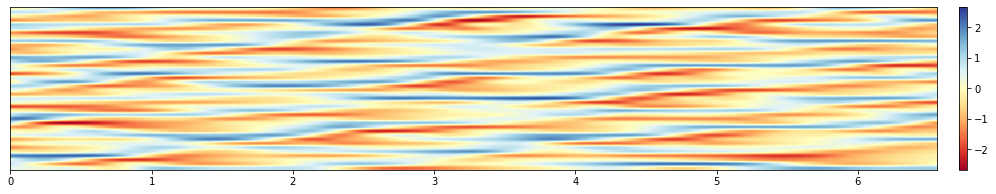

In [18]:
plt.figure(figsize = (20, 3))
plt.imshow(y_test[0].T, cmap = "RdYlBu", aspect = "auto", extent = [0, total_lyapunov_time_pred, 0, 40])
plt.tick_params(axis='both', which='both', left = False, labelleft = False, labelbottom = True, bottom = True) 
plt.colorbar(pad = 0.02)
# plt.xlabel("Lyapunov Time")
# plt.title("Actual")
plt.savefig("lorenz_actual.png", facecolor = "white", bbox_inches = "tight")
plt.show()

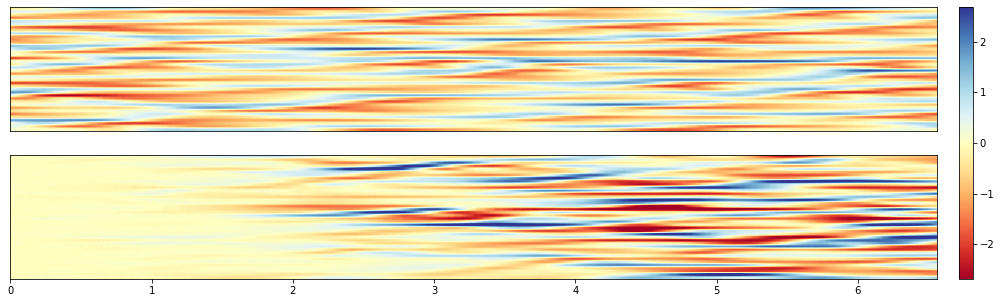

In [16]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "lorenz_RNN", pred_only = True)

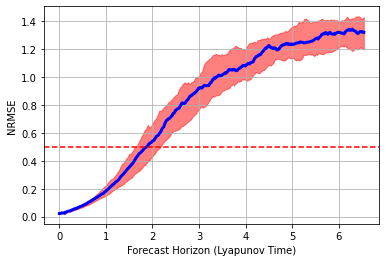

It takes around 1.89 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.077
Median NRMSE at 1.0 Lyapunov Time: 0.183
Median NRMSE at 2.0 Lyapunov Time: 0.542
Median NRMSE at 5.0 Lyapunov Time: 1.233


In [ ]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "lorenz")
res_single.plot_rmse(save_name = "Figure3-2_RNN_Prediction_Horizon")
print()
res_single.get_loss()